In [29]:
# Google Colab Setup: Ensure necessary libraries are installed
!pip install scikit-learn pandas matplotlib

# Import necessary libraries
from google.colab import files
import os
import zipfile
import pandas as pd
import re
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

print("Libraries imported successfully!")

Libraries imported successfully!


In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
# Step 1: Upload and Extract the ZIP File
uploaded_zip_path = '/content/drive/MyDrive/CIS_694/Combined_Spam_Ham.zip'  # Path for the uploaded ZIP file
extracted_folder_path = '/content/drive/MyDrive/CIS_694/'

# Unzip the file
print("Unzipping the file...")
with zipfile.ZipFile(uploaded_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

print(f"Files extracted to: {extracted_folder_path}")

Unzipping the file...
Files extracted to: /content/drive/MyDrive/CIS_694/


In [32]:
# Step 2: Load Data and Extract Features
email_folder_path = os.path.join(extracted_folder_path, '/content/drive/MyDrive/CIS_694/Combined_Spam_Ham')

email_data = []
print("Loading and extracting features from email files...")
for email_file in os.listdir(email_folder_path):
    with open(os.path.join(email_folder_path, email_file), 'r', encoding='utf-8', errors='ignore') as file:
        content = file.read()
        sender = re.search(r"From: (.*)", content)
        receiver = re.search(r"To: (.*)", content)
        subject = re.search(r"Subject: (.*)", content)
        body_start = content.find("\n\n")
        body = content[body_start:].strip() if body_start != -1 else ''
        email_data.append({
            'FileName': email_file,
            'Sender': sender.group(1).strip() if sender else None,
            'Receiver': receiver.group(1).strip() if receiver else None,
            'Subject': subject.group(1).strip() if subject else None,
            'Body': body.strip()
        })

email_df = pd.DataFrame(email_data)

# Print DataFrame size and head/tail
print(f"Original DataFrame: {email_df.shape[0]} rows, {email_df.shape[1]} columns")
print("DataFrame head:")
print(email_df.head())
print("DataFrame tail:")
print(email_df.tail())

Loading and extracting features from email files...
Original DataFrame: 5798 rows, 5 columns
DataFrame head:
                                 FileName  \
0  00001.1a31cc283af0060967a233d26548a6ce   
1  00001.317e78fa8ee2f54cd4890fdc09ba8176   
2  00001.7848dde101aa985090474a91ec93fcf0   
3  00001.7c53336b37003a9286aba55d2945844c   
4  00002.5a587ae61666c5aa097c8e866aedcc59   

                                    Sender  \
0           Robert Elz <kre@munnari.OZ.AU>   
1   "Start Now" <startnow2002@hotmail.com>   
2                      12a1mailbot1@web.de   
3           Robert Elz <kre@munnari.OZ.AU>   
4  Chris Garrigues <cwg-exmh@DeepEddy.Com>   

                                Receiver                         Subject  \
0          yyyy@localhost.netnoteinc.com        Re: New Sequences Window   
1          yyyy@localhost.netnoteinc.com    [ILUG] STOP THE MLM INSANITY   
2  zzzz@localhost.spamassassin.taint.org  Life Insurance - Why Pay More?   
3          zzzz@localhost.netnoteinc.co

In [35]:
# Save the DataFrame to a CSV file
output_csv_path = os.path.join(extracted_folder_path, '/content/drive/MyDrive/CIS_694/email_features.csv')
email_df.to_csv(output_csv_path, index=False, encoding='utf-8')

# Confirm the file has been saved
print(f"CSV file saved at: {output_csv_path}")

CSV file saved at: /content/drive/MyDrive/CIS_694/email_features.csv


In [36]:
# Download the CSV file
files.download(output_csv_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
print("Data types of features:")
print(email_df.dtypes)

Data types of features:
FileName    object
Sender      object
Receiver    object
Subject     object
Body        object
dtype: object


In [38]:
import re
from nltk.corpus import stopwords
import nltk

# Download stopwords from NLTK (if not already done)
nltk.download('stopwords')

def clean_text(text):
    # Step 1: Remove HTML tags
    text = re.sub(r'<[^>]+>', ' ', text)  # Removes HTML tags like <html>, <body>, etc.
    # Step 2: Remove non-alphanumeric characters (except spaces)
    text = re.sub(r'[^\w\s]', ' ', text)
    # Step 3: Remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    # Step 4: Remove email addresses
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)
    # Step 5: Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Step 6: Remove numbers
    text = re.sub(r'\d+', '', text)
    # Step 7: Remove programming keywords or system-specific tokens
    text = re.sub(r'\b(html|body|font|color|size|center|pythonnet|cbgovernmentgw|gward)\b', '', text, flags=re.IGNORECASE)
    # Step 8: Convert to lowercase
    text = text.lower()
    # Step 9: Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    # Step 10: Join the cleaned words back into a single string
    cleaned_text = ' '.join(filtered_words)
    return cleaned_text.strip()

# Apply the updated clean_text function to the 'Body' column
email_df['Cleaned_Body'] = email_df['Body'].apply(clean_text)

# Create a new DataFrame with preprocessed columns
preprocessed_email_df = email_df[['FileName', 'Sender', 'Receiver', 'Subject', 'Cleaned_Body']].copy()

# Print preprocessed DataFrame size and head/tail for verification
print(f"Preprocessed DataFrame: {preprocessed_email_df.shape[0]} rows, {preprocessed_email_df.shape[1]} columns")
print("Preprocessed DataFrame head:")
print(preprocessed_email_df.head())
print("Preprocessed DataFrame tail:")
print(preprocessed_email_df.tail())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Preprocessed DataFrame: 5798 rows, 5 columns
Preprocessed DataFrame head:
                                 FileName  \
0  00001.1a31cc283af0060967a233d26548a6ce   
1  00001.317e78fa8ee2f54cd4890fdc09ba8176   
2  00001.7848dde101aa985090474a91ec93fcf0   
3  00001.7c53336b37003a9286aba55d2945844c   
4  00002.5a587ae61666c5aa097c8e866aedcc59   

                                    Sender  \
0           Robert Elz <kre@munnari.OZ.AU>   
1   "Start Now" <startnow2002@hotmail.com>   
2                      12a1mailbot1@web.de   
3           Robert Elz <kre@munnari.OZ.AU>   
4  Chris Garrigues <cwg-exmh@DeepEddy.Com>   

                                Receiver                         Subject  \
0          yyyy@localhost.netnoteinc.com        Re: New Sequences Window   
1          yyyy@localhost.netnoteinc.com    [ILUG] STOP THE MLM INSANITY   
2  zzzz@localhost.spamassassin.taint.org  Life Insurance - Why Pay More?   
3          zzzz@localhost.netnoteinc.com        Re: New Sequences Window  

In [39]:
preprocessed_email_df.to_csv('/content/drive/MyDrive/CIS_694/Preprocessed_emails.csv', index=False)
print("Preprocessed DataFrame saved as 'Preprocessed_emails.csv'")
files.download('/content/drive/MyDrive/CIS_694/Preprocessed_emails.csv')

Preprocessed DataFrame saved as 'Preprocessed_emails.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [40]:
# Step 4: Bootstrapping to Create a Larger Dataset
desired_rows = 15000
bootstrapped_df = preprocessed_email_df.sample(n=desired_rows, replace=True, random_state=42).reset_index(drop=True)

print(f"Bootstrapped DataFrame: {bootstrapped_df.shape[0]} rows, {bootstrapped_df.shape[1]} columns")
print("Bootstrapped DataFrame head:")
print(bootstrapped_df.head())
print("Bootstrapped DataFrame tail:")
print(bootstrapped_df.tail())

Bootstrapped DataFrame: 15000 rows, 5 columns
Bootstrapped DataFrame head:
                                 FileName  \
0  00216.53a04d271ae7b0752fef521c2d5709f7   
1  02095.3a693b19dba1a74951afa2302b39c23a   
2  01931.95bc125f167b45a2fe51796fc69af04c   
3  01896.516f258e3f8185d4a0e002a7d806bddf   
4  01093.58b9c5035d2291301ff2d0e9c36b0670   

                                              Sender  \
0              Wesley Darlington <wesley@yelsew.com>   
1             fark <rssfeeds@spamassassin.taint.org>   
2  "hyatt@mozilla" <rssfeeds@spamassassin.taint.org>   
3       boingboing <rssfeeds@spamassassin.taint.org>   
4                               bcbridge@hotmail.com   

                                Receiver  \
0          yyyy@localhost.netnoteinc.com   
1  yyyy@localhost.spamassassin.taint.org   
2  yyyy@localhost.spamassassin.taint.org   
3  yyyy@localhost.spamassassin.taint.org   
4          yyyy@localhost.netnoteinc.com   

                                             Subject

In [41]:
print(f"Bootstrapped DataFrame: {bootstrapped_df.shape[0]} rows, {preprocessed_email_df.shape[1]} columns")


Bootstrapped DataFrame: 15000 rows, 5 columns


In [42]:
# Handle missing values by removing rows with null values
print("Handling missing values by removing rows with null values...")

# Check for any null values in required columns
print("Before dropping null values:")
print(bootstrapped_df.isnull().sum())

# Drop rows where any of the key columns ('Sender', 'Subject', 'Cleaned_Body') are null
bootstrapped_df = bootstrapped_df.dropna(subset=['Sender', 'Subject', 'Cleaned_Body']).reset_index(drop=True)

# Recreate the 'Combined_Text' column after dropping null rows
bootstrapped_df['Combined_Text'] = (
    bootstrapped_df['Sender'] + " " +
    bootstrapped_df['Subject'] + " " +
    bootstrapped_df['Cleaned_Body']
)

# Ensure all entries in 'Combined_Text' are strings
bootstrapped_df['Combined_Text'] = bootstrapped_df['Combined_Text'].astype(str)

# Check if all values are strings and no NaN values exist
print("After dropping null values:")
print(bootstrapped_df.isnull().sum())
print("Sample Combined_Text column data:")
print(bootstrapped_df['Combined_Text'].head())
print("Are all entries strings?", bootstrapped_df['Combined_Text'].apply(lambda x: isinstance(x, str)).all())

Handling missing values by removing rows with null values...
Before dropping null values:
FileName         0
Sender           7
Receiver        69
Subject         20
Cleaned_Body     0
dtype: int64
After dropping null values:
FileName          0
Sender            0
Receiver         62
Subject           0
Cleaned_Body      0
Combined_Text     0
dtype: int64
Sample Combined_Text column data:
0    Wesley Darlington <wesley@yelsew.com> Re: [ILU...
1    fark <rssfeeds@spamassassin.taint.org> Bank ro...
2    "hyatt@mozilla" <rssfeeds@spamassassin.taint.o...
3    boingboing <rssfeeds@spamassassin.taint.org> E...
4    bcbridge@hotmail.com RE: MEN & WOMEN, TURBO BO...
Name: Combined_Text, dtype: object
Are all entries strings? True


In [43]:
print(f"DataFrame size after bootstrapping and handling null values: {bootstrapped_df.shape[0]} rows, {bootstrapped_df.shape[1]} columns")

DataFrame size after bootstrapping and handling null values: 14980 rows, 6 columns


In [44]:
# Step 5: Add Class Labels Based on Extended Spam Keywords
def classify_email(subject, body):
    spam_keywords = [
        'win', 'free', 'urgent', 'offer', 'loan', 'click', 'subscribe',
        'money', 'cash', 'credit', 'gift', 'winner', 'deal', 'buy now',
        'limited time', 'discount', 'promotion', 'guarantee', 'trial', 'stop', 'end','exclusive', 'claim now'
    ]
    content = f"{subject} {body}".lower()
    return int(any(keyword in content for keyword in spam_keywords))

bootstrapped_df['Spam'] = bootstrapped_df.apply(
    lambda row: classify_email(row['Subject'], row['Cleaned_Body']), axis=1
)

# Print updated DataFrame head/tail
print("Bootstrapped DataFrame with Spam labels head:")
print(bootstrapped_df.head())
print("Bootstrapped DataFrame with Spam labels tail:")
print(bootstrapped_df.tail())

Bootstrapped DataFrame with Spam labels head:
                                 FileName  \
0  00216.53a04d271ae7b0752fef521c2d5709f7   
1  02095.3a693b19dba1a74951afa2302b39c23a   
2  01931.95bc125f167b45a2fe51796fc69af04c   
3  01896.516f258e3f8185d4a0e002a7d806bddf   
4  01093.58b9c5035d2291301ff2d0e9c36b0670   

                                              Sender  \
0              Wesley Darlington <wesley@yelsew.com>   
1             fark <rssfeeds@spamassassin.taint.org>   
2  "hyatt@mozilla" <rssfeeds@spamassassin.taint.org>   
3       boingboing <rssfeeds@spamassassin.taint.org>   
4                               bcbridge@hotmail.com   

                                Receiver  \
0          yyyy@localhost.netnoteinc.com   
1  yyyy@localhost.spamassassin.taint.org   
2  yyyy@localhost.spamassassin.taint.org   
3  yyyy@localhost.spamassassin.taint.org   
4          yyyy@localhost.netnoteinc.com   

                                             Subject  \
0                     Re:

In [45]:
bootstrapped_df.to_csv('/content/drive/MyDrive/CIS_694/Class_label_emails.csv', index=False)
print("Bootstrapped DataFrame with class labels saved as 'Class_label_emails.csv'")
files.download('/content/drive/MyDrive/CIS_694/Class_label_emails.csv')

Bootstrapped DataFrame with class labels saved as 'Class_label_emails.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [46]:
 #!pip install --upgrade --force-reinstall numpy==1.26.4 scipy==1.13.1 gensim

In [47]:
!pip install gensim
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 6: Prepare Data for Model Training using Word2Vec
tokenized_texts = bootstrapped_df['Combined_Text'].apply(lambda x: x.split())

# Train a Word2Vec model on the tokenized texts
word2vec_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)

# Function to vectorize text using Word2Vec
def vectorize_texts(texts, model):
    vectors = []
    for text in texts:
        tokens = text.split()
        token_vectors = [model.wv[word] for word in tokens if word in model.wv]
        if token_vectors:
            vectors.append(np.mean(token_vectors, axis=0))
        else:
            vectors.append(np.zeros(model.vector_size))
    return np.array(vectors)

# Vectorize the data
X_bootstrapped = vectorize_texts(bootstrapped_df['Combined_Text'], word2vec_model)
y_bootstrapped = bootstrapped_df['Spam']


In [48]:
# Step 7: Split Data for Training and Testing
X_train, X_test, y_train, y_test = train_test_split(
    X_bootstrapped, y_bootstrapped, test_size=0.3, random_state=42)

Training Random Forest...
Training Logistic Regression...
Training SVM...
Model Performance Comparison:
                 Model  Accuracy  Precision    Recall  F1-Score
0        Random Forest  0.969960   0.969826  0.969960  0.969657
1  Logistic Regression  0.824878   0.814643  0.824878  0.816846
2                  SVM  0.846907   0.839122  0.846907  0.839921


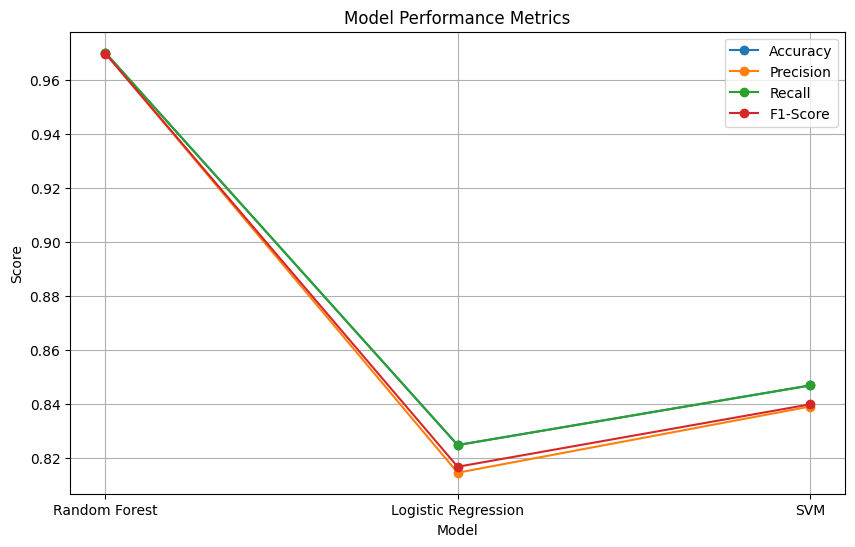

In [49]:
# Step 8: Train and Evaluate Multiple Models
models = {
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "SVM": SVC(random_state=42)
}

results = []

for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    results.append({
        'Model': model_name,
        'Accuracy': acc,
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score']
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Print and visualize the results
print("Model Performance Comparison:")
print(results_df)

plt.figure(figsize=(10, 6))
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)
plt.title('Model Performance Metrics')
plt.xlabel('Model')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()

In [50]:
# Step 9: Use the Best Model for Future Predictions

best_model_name = results_df.sort_values(by='Accuracy', ascending=False).iloc[0]['Model']
print(f"The best performing model is: {best_model_name}")
best_model = models[best_model_name]


# Example Prediction
#example_email = "Ok it's Thanksgiving - so you deserve a FEAST today.And like at Thanksgiving dinner, instead of one main course (like our usual weekly essays), today you're getting a full spread:10 quick-hitter ideas that will make your career better for having read them. A mix of unconventional career strategies, job search hacks, and things I wish I knew earlier.I think you'll like the format — and you'll probably save a thing or three that you'll use forever.Before we dig in…I kinda want to start with the dessert first:"
#example_email = "Some Grading Errors Have Been Found in Short Exam 2. They all have been corrected now. Some of scores of the Short Exam2 have been updated (mostly lowered) now"
#example_vectorized = vectorizer.transform([example_email])
#prediction = best_model.predict(example_vectorized)
#print(f"The example email is classified as: {'Ham' if prediction[0] == 1 else 'Spam'}")

The best performing model is: Random Forest


In [51]:
from ipywidgets import Text, Button, Output, VBox
from IPython.display import display
import numpy as np

# Function to vectorize a single input text using Word2Vec
def vectorize_single_text(text, model):
    tokens = text.split()
    token_vectors = [model.wv[word] for word in tokens if word in model.wv]
    if token_vectors:
        return np.mean(token_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# Create widgets for user interaction
text_input = Text(description="Email:", placeholder="Enter email content here...")
predict_button = Button(description="Classify")
output = Output()

# Define prediction function
def predict_email_type(change):
    email_content = text_input.value
    if not email_content.strip():
        with output:
            output.clear_output()
            print("Please enter a valid email.")
        return

    # Vectorize the input email
    email_vectorized = vectorize_single_text(email_content, word2vec_model).reshape(1, -1)

    # Predict using the trained model
    prediction = best_model.predict(email_vectorized)
    with output:
        output.clear_output()
        print(f"The email is classified as: {'Spam' if prediction[0] == 1 else 'Ham'}")

# Attach the handler to the button
predict_button.on_click(predict_email_type)

# Display the UI
ui = VBox([text_input, predict_button, output])
display(ui)
